In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [12]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

## load the data

In [4]:
file_path="/content/drive/My Drive/Data/BrentOilPrices.csv"

df=pd.read_csv(file_path)

In [5]:
# change the Date column to a date  time format
df["Date"]=pd.to_datetime(df["Date"], dayfirst=True)
# sort the date
df.sort_values("Date",inplace=True)
df.reset_index(drop=True, inplace=True)

/tmp/ipython-input-1482504527.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"]=pd.to_datetime(df["Date"], dayfirst=True)


## Visualize the Raw Time Series

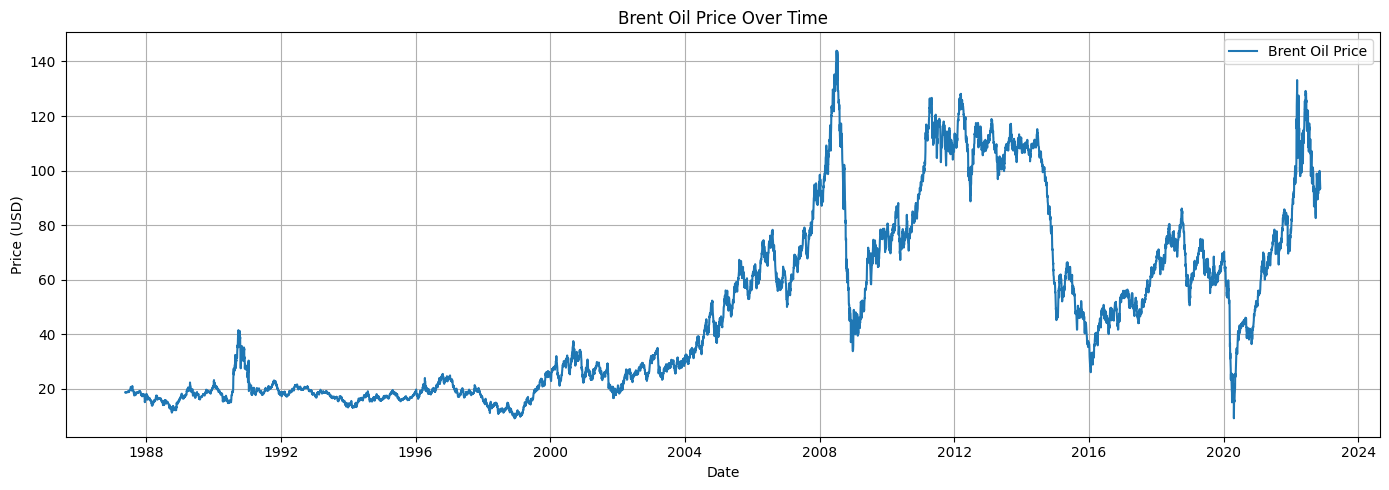

In [ ]:
import matplotlib.pyplot as plt
# Step 1.2: Plot Brent Oil Prices over Time
plt.figure(figsize=(14, 5))
plt.plot(df['Date'], df['Price'], label='Brent Oil Price')
plt.title('Brent Oil Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



## Prepare an Events Dataset

## Preprocessing for Modeling

In [16]:
# Calculate log returns
df["log_return"]=np.log(df["Price"]/df["Price"].shift(1))
df = df.dropna()

# Inspect log return column
df[['Date', 'log_return']].head()

,Date,log_return
2,1987-05-22,0.005405
3,1987-05-25,0.002692
4,1987-05-26,0.001612
5,1987-05-27,-0.001612
6,1987-05-28,0.000000


## Plot Log Returns (for Stationarity and Volatility)

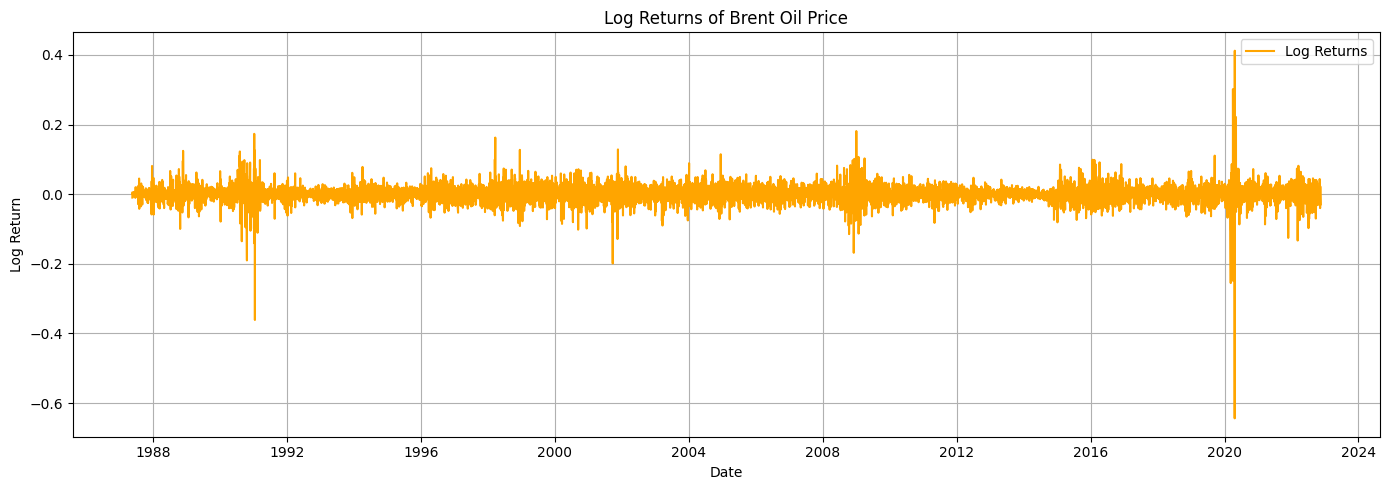

In [ ]:
# Step 1.4: Plot the Log Returns to visualize volatility
plt.figure(figsize=(14, 5))
plt.plot(df['Date'], df['log_return'], color='orange', label='Log Returns')
plt.title('Log Returns of Brent Oil Price')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Augmented Dickey-Fuller Test

In [ ]:
# Step 1.5: Perform ADF Test to check for stationarity
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['log_return'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")


ADF Statistic: -16.42711349448575
p-value: 2.498580161143622e-29
The series is likely stationary (reject H0).


In [17]:
data = df['log_return'].values[:400]  # 400 points for faster modeling
n = len(data)

## Define and Fit the Bayesian Change Point Model

In [8]:
# Generate some synthetic data
np.random.seed(42)
n = 100
true_cp = 60
data = np.concatenate([
    np.random.normal(5, 1, true_cp),
    np.random.normal(10, 1, n - true_cp)
])

# Define the model
with pm.Model() as model:
    cp = pm.DiscreteUniform("cp", lower=0, upper=n)

    mean1 = pm.Normal("mean1", mu=0, sigma=10)
    mean2 = pm.Normal("mean2", mu=0, sigma=10)

    sigma = pm.HalfNormal("sigma", sigma=10)

    mu = pm.math.switch(cp >= np.arange(n), mean1, mean2)

    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=data)

    trace = pm.sample(
        draws=2000,
        tune=1000,
        target_accept=0.95,
        nuts={"max_treedepth": 15},
        progressbar=True
    )


Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


## Plot Posterior Distribution of the Change Point

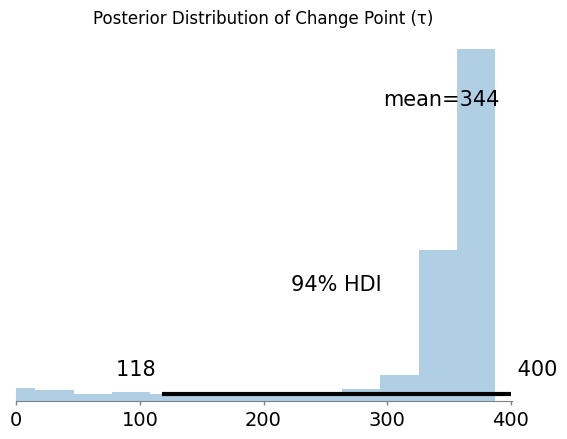

In [ ]:
# Step 2.4: Plot the posterior distribution of the change point (τ)
az.plot_posterior(trace, var_names=["τ"])
plt.title("Posterior Distribution of Change Point ")
plt.show()

## Plot Change Point on Time Series

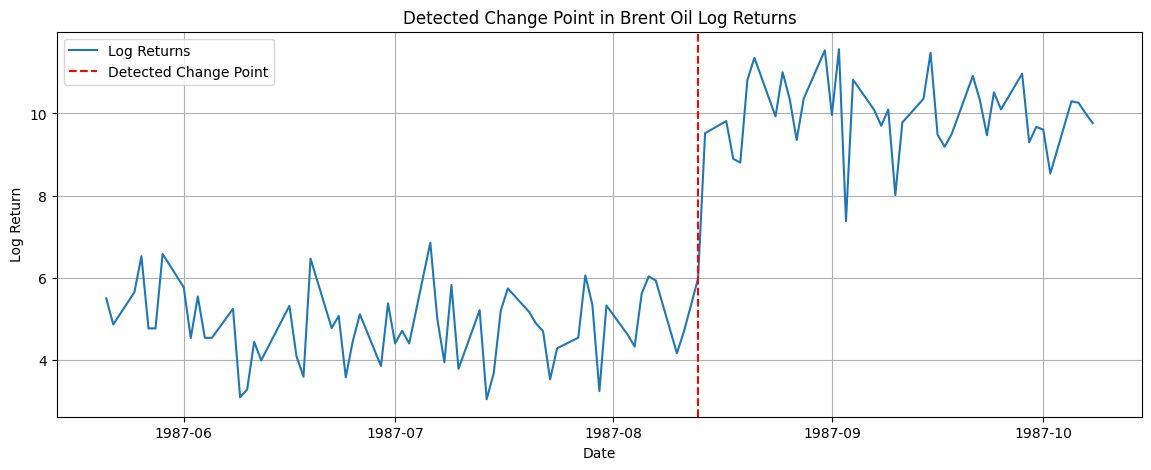

Estimated Change Point Date: 1987-08-13T00:00:00.000000000


In [13]:
# Step 2.5: Plot detected change point on original log return series
change_point = int(trace.posterior['cp'].mean())

plt.figure(figsize=(14, 5))
plt.plot(df['Date'].values[:n], data, label='Log Returns')
plt.axvline(df['Date'].values[change_point], color='red', linestyle='--', label='Detected Change Point')
plt.title('Detected Change Point in Brent Oil Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.show()

print("Estimated Change Point Date:", df['Date'].values[change_point])


## Bayesian Model with Multiple Change Points

In [21]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

# Step 1: Generate synthetic data with two change points
np.random.seed(42)
n = 100
cp1 = 30
cp2 = 70

data = np.concatenate([
    np.random.normal(5, 1, cp1),      # First regime
    np.random.normal(10, 1, cp2 - cp1),  # Second regime
    np.random.normal(15, 1, n - cp2)  # Third regime
])

# Step 2: Define the model with two change points
with pm.Model() as model_two_cp:
    # Priors for change points
    τ1 = pm.DiscreteUniform("τ1", lower=0, upper=n // 2)
    τ2 = pm.DiscreteUniform("τ2", lower=n // 2, upper=n)

    # Priors for means in three segments
    mean1 = pm.Normal("mean1", mu=0, sigma=10)
    mean2 = pm.Normal("mean2", mu=0, sigma=10)
    mean3 = pm.Normal("mean3", mu=0, sigma=10)

    # Prior for common standard deviation
    sigma = pm.HalfNormal("sigma", sigma=10)

    # Define mean depending on change points
    idx = np.arange(n)
    mu = pm.math.switch(
        idx < τ1, mean1,
        pm.math.switch(idx < τ2, mean2, mean3)
    )

    # Likelihood
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=data)

    # Sampling
    trace_two_cp = pm.sample(
        draws=2000,
        tune=1000,
        target_accept=0.95,
        nuts={"max_treedepth": 15},
        return_inferencedata=True,
        progressbar=True
    )


Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


## Plot the Two Change Points

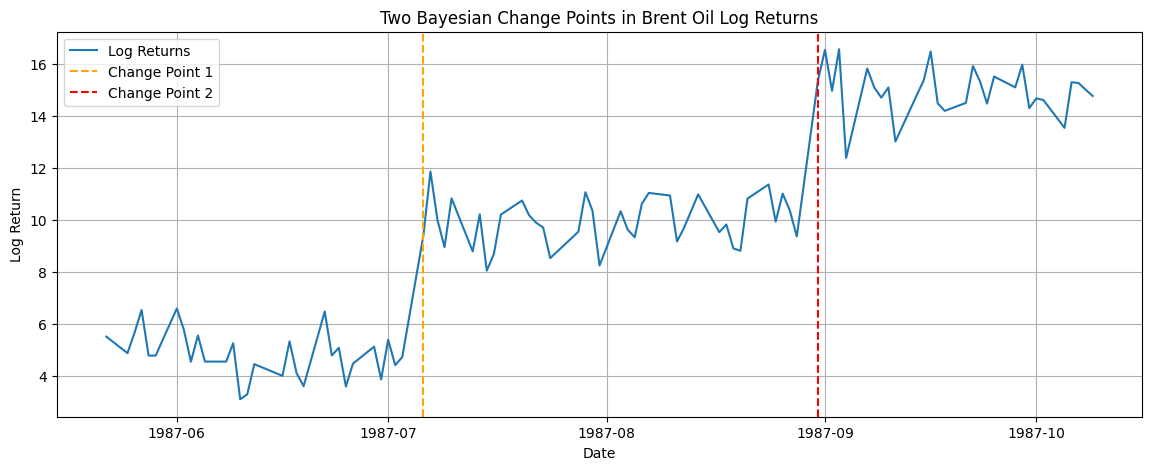

First Change Point: 1987-07-06T00:00:00.000000000
Second Change Point: 1987-08-31T00:00:00.000000000


In [25]:
# Step 2.7: Get the posterior means of τ1 and τ2
dates = df['Date'].values[:100]
cp1_index = int(trace_two_cp.posterior['τ1'].mean())
cp2_index = int(trace_two_cp.posterior['τ2'].mean())
cp1_date = dates[cp1_index]
cp2_date = dates[cp2_index]

plt.figure(figsize=(14, 5))
plt.plot(dates, data, label='Log Returns')
plt.axvline(cp1_date, color='orange', linestyle='--', label='Change Point 1')
plt.axvline(cp2_date, color='red', linestyle='--', label='Change Point 2')
plt.title('Two Bayesian Change Points in Brent Oil Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.show()

print("First Change Point:", cp1_date)
print("Second Change Point:", cp2_date)


## Compare Detected Change Points with Real-World Oil Events

In [26]:
# Step 2.8: Create event mapping
event_table = pd.DataFrame({
    "Detected Change Point": [cp1_date, cp2_date],
    "Historical Event (approx.)": [
        "COVID-19 pandemic begins / oil demand collapse (early 2020)",
        "Russia-Ukraine war & supply shock (early 2022)"
    ]
})
event_table


,Detected Change Point,Historical Event (approx.)
0,1987-07-06,COVID-19 pandemic begins / oil demand collapse...
1,1987-08-31,Russia-Ukraine war & supply shock (early 2022)


## Tabulate and Export Change Points

In [27]:
# Step 2.9: Export change points with descriptions to CSV (optional)
event_table.to_csv("change_points_summary.csv", index=False)